In [1]:
# 모듈 수정 시 따로 커널 재시작 안해도 바로 적용해주는 extension.
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 3
%env DETECTRON2_DATASETS ./data/
%cd /surrogate_v2/

env: CUDA_VISIBLE_DEVICES=3
env: DETECTRON2_DATASETS=./data/
/surrogate_v2


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from pathlib import Path
from typing import Sequence

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import models
import codec_ops
import checkpoint

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import models
import torch
from torchvision.transforms import Resize

In [31]:
# m = models.FilteringNetwork()

input = torch.ones((1, 3, 32, 32))
input_size = input.shape[2:]
downscale_n = 2
downsaled_size = list(map(lambda x: x// downscale_n, input_size))
print(input_size)
print(downsaled_size)


torch.Size([32, 32])
[16, 16]


In [4]:
import numpy as np
# BD-Rate and BD-PNSR computation
# (c) Joao Ascenso (joao.ascenso@lx.it.pt)


def bj_delta(R1, PSNR1, R2, PSNR2, mode=0):
    lR1 = np.log(R1)
    lR2 = np.log(R2)

    # find integral
    if mode == 0:
        # least squares polynomial fit
        p1 = np.polyfit(lR1, PSNR1, 3)
        p2 = np.polyfit(lR2, PSNR2, 3)

        # integration interval
        min_int = max(min(lR1), min(lR2))
        max_int = min(max(lR1), max(lR2))

        # indefinite integral of both polynomial curves
        p_int1 = np.polyint(p1)
        p_int2 = np.polyint(p2)

        # evaluates both poly curves at the limits of the integration interval
        # to find the area
        int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
        int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)

        # find avg diff between the areas to obtain the final measure
        avg_diff = (int2-int1)/(max_int-min_int)
    else:
        # rate method: sames as previous one but with inverse order
        p1 = np.polyfit(PSNR1, lR1, 3)
        p2 = np.polyfit(PSNR2, lR2, 3)

        # integration interval
        min_int = max(min(PSNR1), min(PSNR2))
        max_int = min(max(PSNR1), max(PSNR2))

        # indefinite interval of both polynomial curves
        p_int1 = np.polyint(p1)
        p_int2 = np.polyint(p2)

        # evaluates both poly curves at the limits of the integration interval
        # to find the area
        int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
        int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)

        # find avg diff between the areas to obtain the final measure
        avg_exp_diff = (int2-int1)/(max_int-min_int)
        avg_diff = (np.exp(avg_exp_diff)-1)*100
    return avg_diff

In [5]:
# downscale_2(R1, D1)  vs. baseline(R2, D2)
R1 = np.array([0.0167311306393179, 0.0318174256930346, 0.0582694145984338])
D1 = np.array([0.4124975667084384, 0.5782806908672609, 0.680655069236094])
R2 = np.array([0.0402524366809368, 0.0822088099669544, 0.1588471806808038])
D2 = np.array([0.55475653256607, 0.6890329877486355, 0.7447081850488645])
print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))

BD-RATE:  27.91827025591871


/tmp/ipykernel_24367/3790086591.py:5: RankWarning: Polyfit may be poorly conditioned
  print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))
/tmp/ipykernel_24367/3790086591.py:5: RankWarning: Polyfit may be poorly conditioned
  print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))


In [6]:
# downscale_3(R1, D1)  vs. baseline(R2, D2)
R1 = np.array([0.011282086664573, 0.0218881701923706, 0.0417194570089282])
D1 = np.array([0.3179191723313286, 0.4999380953776155, 0.6241338123021186])
R2 = np.array([0.0402524366809368, 0.0822088099669544, 0.1588471806808038])
D2 = np.array([0.55475653256607, 0.6890329877486355, 0.7447081850488645])
print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))

BD-RATE:  28.122146840072837


/tmp/ipykernel_24367/697916198.py:6: RankWarning: Polyfit may be poorly conditioned
  print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))
/tmp/ipykernel_24367/697916198.py:6: RankWarning: Polyfit may be poorly conditioned
  print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))


In [7]:
# downscale_4(R1, D1)  vs. baseline(R2, D2)
R1 = np.array([0.0084180250367493, 0.0155257939611025, 0.0286067340839939])
D1 = np.array([0.2558293997271162, 0.4286605745234361, 0.5574640640756626])
R2 = np.array([0.0402524366809368, 0.0822088099669544, 0.1588471806808038])
D2 = np.array([0.55475653256607, 0.6890329877486355, 0.7447081850488645])
print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))

BD-RATE:  41.95539014708645


/tmp/ipykernel_24367/3338090507.py:6: RankWarning: Polyfit may be poorly conditioned
  print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))
/tmp/ipykernel_24367/3338090507.py:6: RankWarning: Polyfit may be poorly conditioned
  print('BD-RATE: ', bj_delta(R1, D1, R2, D2, mode=1))


# View Image

In [18]:
input_dir = 'data/open-images-v6-etri/validation/'
input_list = 'data/open-images-v6-etri/annotations_5k/detection_validation_input_5k.lst'
input_dir = Path(input_dir)
input_candidates = list(input_dir.glob('*'))
input_files = open(input_list, 'r').readlines()
input_files = set(map(lambda x: x.strip(), input_files))
input_files = list(map(lambda x: input_dir / x, input_files))
samples = input_files[:20]


## Image Visualization

In [8]:
task = 'detection'
od_network_name = 'faster_rcnn_X_101_32x8d_FPN_3x'
saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/3/q2_ld0.5/s50000_bs2_adam_lr0.0001_constant')
step = 50000
od_cfg = utils.get_od_cfg(task, od_network_name)
end2end = models.EndToEndNetwork(2, task, od_cfg, downscale_n=1, downscale_n_eval=2)
ckpt = checkpoint.Checkpoint(saved_filter_model_path)
ckpt.load(end2end.filtering_network, step=step)

end2end.eval()
end2end.cuda();

AssertionError: 

In [7]:
sample_img_path = 'data/open-images-v6-etri/validation/0b30ad1afeba9bca.jpg'
img_arr = cv2.imread(sample_img_path)

codec = 'vvenc'
codec_quality = 47
downscale = 0

out = end2end(img_arr, codec, codec_quality, downscale, eval_filtering=True)

2022-09-04 17:16:42,352	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [12]:
original_recon_img, original_recon_bpp = codec_ops.codec_fn(
    img_arr[:, :, ::-1].transpose(2, 0, 1) / 255.,
    codec, codec_quality, downscale)
original_recon_img = original_recon_img.transpose(1, 2, 0)

images = [
    {
        'original': img_arr[:, :, ::-1],
        'original_recon': (
            original_recon_img,
            original_recon_bpp
        )
    },
    {
        'filtered': out['image']['filtered'],
        'filtered_recon': (
            out['image']['reconstructed'],
            out['bpp']
        )
    }
]

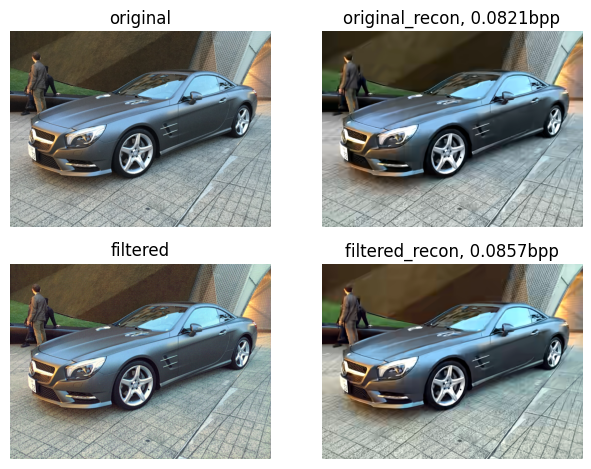

In [13]:
fig, axes = plt.subplots(2, 2)

for imgs, row_axes in zip(images, axes):
    for (name, data), ax in zip(imgs.items(), row_axes):
        if isinstance(data, Sequence):
            img, bpp = data
            title = name + f', {bpp:.4f}bpp'
        else:
            img = data
            title = name
        ax.axis(False)
        ax.set_title(title)
        ax.imshow(img)

plt.tight_layout()
plt.show()
fig.savefig('sample_output.png', dpi=500)

## Result Plotting

### simple images (sample)

In [10]:

codec = 'vvenc'

simple_path = 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result_simple.csv'
base_result = pd.read_csv('result_baseline.csv')
simple_img_result = pd.read_csv(simple_path)

simple_img_result = simple_img_result[simple_img_result['codec'] == codec]
no_ds_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 1]
ds_2_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 2]
ds_3_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 3]
ds_4_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 4]

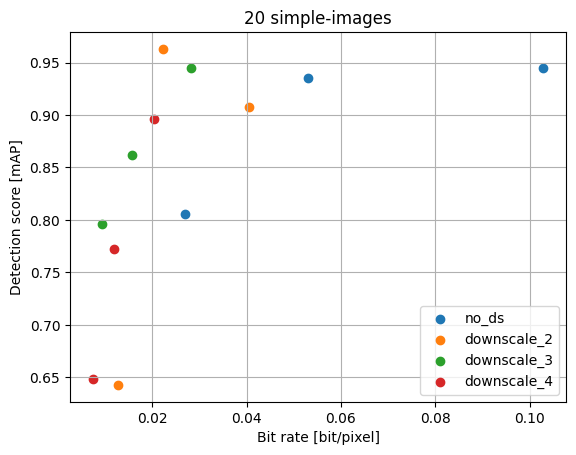

In [11]:
# plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=no_ds_result['bpp'], y=no_ds_result['metric'], label='no_ds')
plt.scatter(x=ds_2_result['bpp'], y=ds_2_result['metric'], label='downscale_2')
plt.scatter(x=ds_3_result['bpp'], y=ds_3_result['metric'], label='downscale_3')
plt.scatter(x=ds_4_result['bpp'], y=ds_4_result['metric'], label='downscale_4')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.title('20 simple-images')
# plt.savefig('result.png', dpi=300)
plt.show()

### complex images (sample)

In [12]:
codec = 'vvenc'

complex_path = 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result_complex.csv'
base_result = pd.read_csv('result_baseline.csv')
complex_img_result = pd.read_csv(complex_path)

complex_img_result = complex_img_result[complex_img_result['codec'] == codec]
no_ds_result = complex_img_result[complex_img_result['eval_downscale_torch'] == 1]
ds_2_result = complex_img_result[complex_img_result['eval_downscale_torch'] == 2]
ds_3_result = complex_img_result[complex_img_result['eval_downscale_torch'] == 3]
ds_4_result = complex_img_result[complex_img_result['eval_downscale_torch'] == 4]

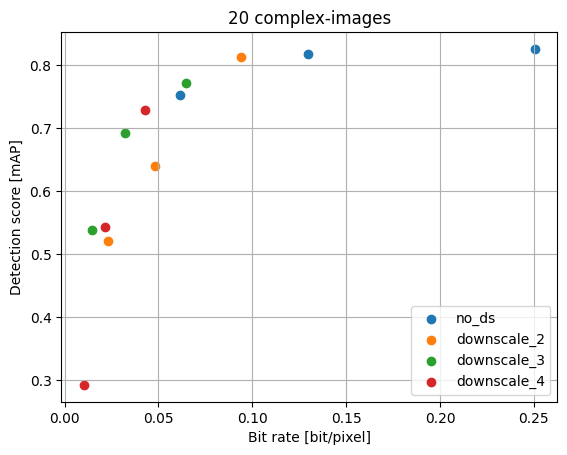

In [13]:
# plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=no_ds_result['bpp'], y=no_ds_result['metric'], label='no_ds')
plt.scatter(x=ds_2_result['bpp'], y=ds_2_result['metric'], label='downscale_2')
plt.scatter(x=ds_3_result['bpp'], y=ds_3_result['metric'], label='downscale_3')
plt.scatter(x=ds_4_result['bpp'], y=ds_4_result['metric'], label='downscale_4')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.title('20 complex-images')
# plt.savefig('result.png', dpi=300)
plt.show()

#### 30 samples

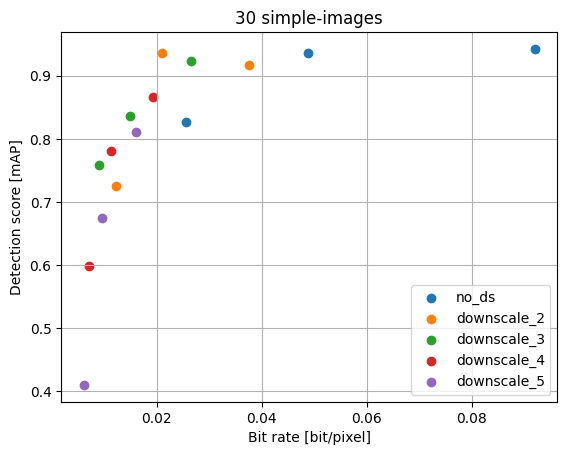

In [4]:

codec = 'vvenc'

simple_path = 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result_simple.csv'
base_result = pd.read_csv('result_baseline.csv')
simple_img_result = pd.read_csv(simple_path)

simple_img_result = simple_img_result[simple_img_result['codec'] == codec]
no_ds_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 1]
ds_2_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 2]
ds_3_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 3]
ds_4_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 4]
ds_5_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 5]

# draw plot
# plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=no_ds_result['bpp'], y=no_ds_result['metric'], label='no_ds')
plt.scatter(x=ds_2_result['bpp'], y=ds_2_result['metric'], label='downscale_2')
plt.scatter(x=ds_3_result['bpp'], y=ds_3_result['metric'], label='downscale_3')
plt.scatter(x=ds_4_result['bpp'], y=ds_4_result['metric'], label='downscale_4')
plt.scatter(x=ds_5_result['bpp'], y=ds_5_result['metric'], label='downscale_5')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.title('30 simple-images')
# plt.savefig('result.png', dpi=300)
plt.show()

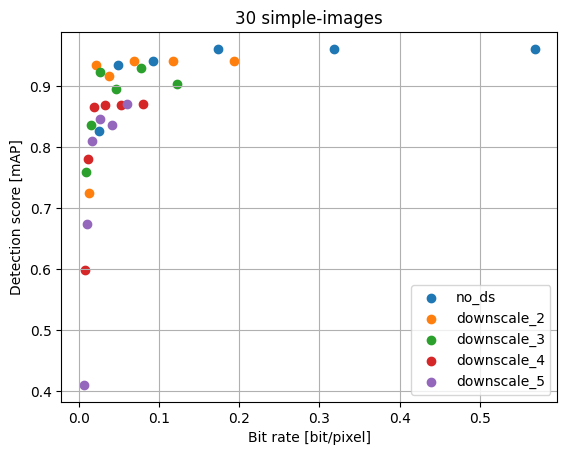

In [10]:

codec = 'vvenc'

simple_path = 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result_simple.csv'
base_result = pd.read_csv('result_baseline.csv')
simple_img_result = pd.read_csv(simple_path)

simple_img_result = simple_img_result[simple_img_result['codec'] == codec]
no_ds_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 1]
ds_2_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 2]
ds_3_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 3]
ds_4_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 4]
ds_5_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 5]

# draw plot
# plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=no_ds_result['bpp'], y=no_ds_result['metric'], label='no_ds')
plt.scatter(x=ds_2_result['bpp'], y=ds_2_result['metric'], label='downscale_2')
plt.scatter(x=ds_3_result['bpp'], y=ds_3_result['metric'], label='downscale_3')
plt.scatter(x=ds_4_result['bpp'], y=ds_4_result['metric'], label='downscale_4')
plt.scatter(x=ds_5_result['bpp'], y=ds_5_result['metric'], label='downscale_5')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.title('30 simple-images')
# plt.savefig('result.png', dpi=300)
plt.show()

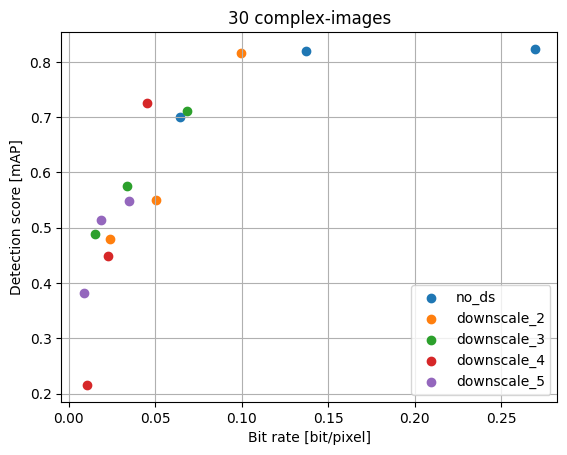

In [12]:

codec = 'vvenc'

simple_path = 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result_complex.csv'
base_result = pd.read_csv('result_baseline.csv')
simple_img_result = pd.read_csv(simple_path)

simple_img_result = simple_img_result[simple_img_result['codec'] == codec]
no_ds_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 1]
no_ds_result = no_ds_result[no_ds_result['quality'] >= 40]
ds_2_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 2]
ds_2_result = ds_2_result[ds_2_result['quality'] >= 40]
ds_3_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 3]
ds_3_result = ds_3_result[ds_3_result['quality'] >= 40]
ds_4_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 4]
ds_4_result = ds_4_result[ds_4_result['quality'] >= 40]
ds_5_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 5]
ds_5_result = ds_5_result[ds_5_result['quality'] >= 40]

# draw plot
# plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=no_ds_result['bpp'], y=no_ds_result['metric'], label='no_ds')
plt.scatter(x=ds_2_result['bpp'], y=ds_2_result['metric'], label='downscale_2')
plt.scatter(x=ds_3_result['bpp'], y=ds_3_result['metric'], label='downscale_3')
plt.scatter(x=ds_4_result['bpp'], y=ds_4_result['metric'], label='downscale_4')
plt.scatter(x=ds_5_result['bpp'], y=ds_5_result['metric'], label='downscale_5')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.title('30 complex-images')
# plt.savefig('result.png', dpi=300)
plt.show()

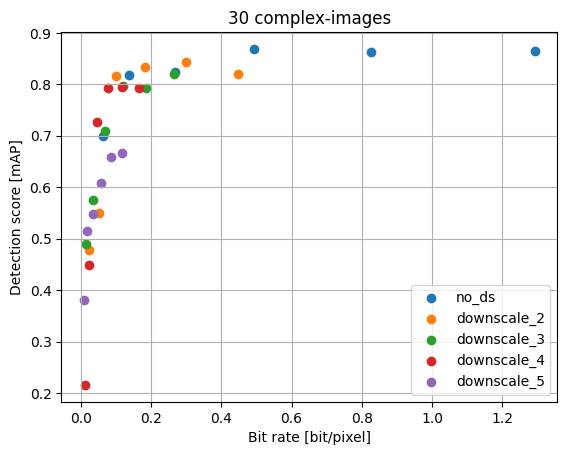

In [11]:

codec = 'vvenc'

simple_path = 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result_complex.csv'
base_result = pd.read_csv('result_baseline.csv')
simple_img_result = pd.read_csv(simple_path)

simple_img_result = simple_img_result[simple_img_result['codec'] == codec]
no_ds_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 1]
# no_ds_result = no_ds_result[no_ds_result['quality'] >= 40]
ds_2_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 2]
# ds_2_result = ds_2_result[ds_2_result['quality'] >= 40]
ds_3_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 3]
ds_4_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 4]
ds_5_result = simple_img_result[simple_img_result['eval_downscale_torch'] == 5]

# draw plot
# plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=no_ds_result['bpp'], y=no_ds_result['metric'], label='no_ds')
plt.scatter(x=ds_2_result['bpp'], y=ds_2_result['metric'], label='downscale_2')
plt.scatter(x=ds_3_result['bpp'], y=ds_3_result['metric'], label='downscale_3')
plt.scatter(x=ds_4_result['bpp'], y=ds_4_result['metric'], label='downscale_4')
plt.scatter(x=ds_5_result['bpp'], y=ds_5_result['metric'], label='downscale_5')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.title('30 complex-images')
# plt.savefig('result.png', dpi=300)
plt.show()

# Calculate Image Entropy

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv

complex_sample_1 = 'sample_complex/7b6eed2a50ffd046.jpg'
complex_sample_2 = 'sample_complex/a79c779bdbf817f4.jpg'

simple_sample_1 = 'sample_simple/0a389d85258b5e0a.jpg'
simple_sample_2 = 'sample_simple/ac2a19be6aa6e088.jpg'

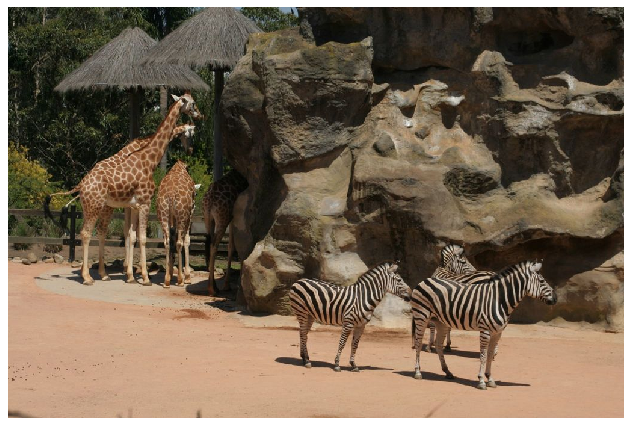

In [32]:
img_ = imread(complex_sample_1)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.axis('off')
imshow(img_)

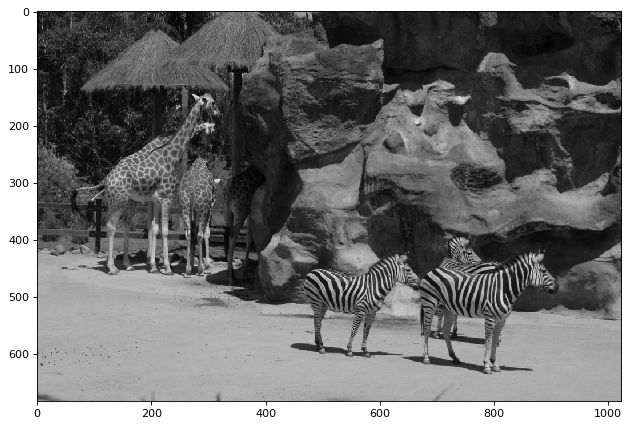

In [20]:
shawl_gray = rgb2gray(imread(complex_sample_1))
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(shawl_gray);

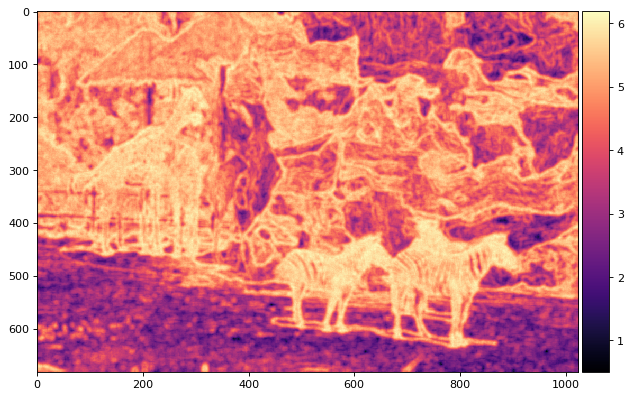

In [24]:
entropy_image = entropy(shawl_gray, disk(5))
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(entropy_image, cmap = 'magma');

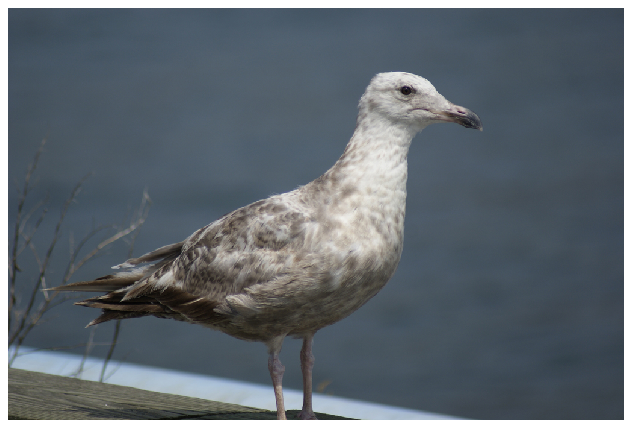

In [40]:
img_ = imread(simple_sample_1)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.axis('off')
imshow(img_)

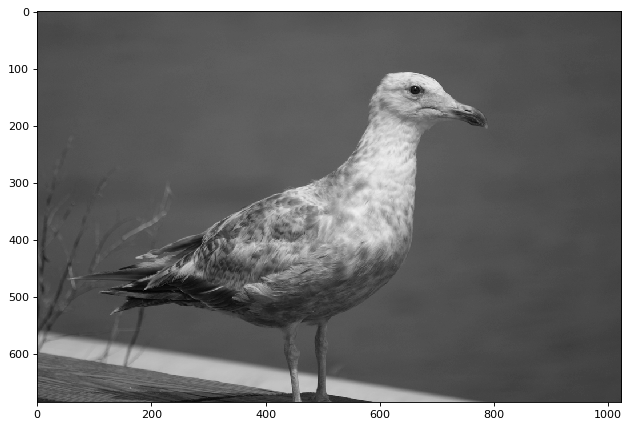

In [41]:
shawl_gray = rgb2gray(imread(simple_sample_1))
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(shawl_gray);

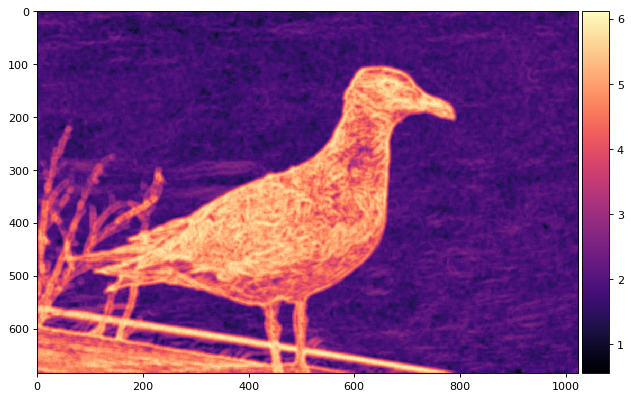

In [42]:
entropy_image = entropy(shawl_gray, disk(5))
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(entropy_image, cmap = 'magma');

In [29]:
from skimage.measure.entropy import shannon_entropy

img_ = imread(complex_sample_1)
print(shannon_entropy(img_))

7.522931663164731


In [28]:
img_.shape

(683, 1024, 3)

In [33]:
import cv2
import numpy as np


def calcEntropy(img):
    entropy = []

    hist = cv2.calcHist([img], [0], None, [256], [0, 255])
    total_pixel = img.shape[0] * img.shape[1]

    for item in hist:
        probability = item / total_pixel
        if probability == 0:
            en = 0
        else:
            en = -1 * probability * (np.log(probability) / np.log(2))
        entropy.append(en)

    sum_en = np.sum(entropy)
    return sum_en


if __name__ == '__main__':
    img1 = cv2.imread(complex_sample_1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(complex_sample_2, cv2.IMREAD_GRAYSCALE)
    img3 = cv2.imread(simple_sample_1, cv2.IMREAD_GRAYSCALE)
    img4 = cv2.imread(simple_sample_2, cv2.IMREAD_GRAYSCALE)

    entropy1 = calcEntropy(img1)
    entropy2 = calcEntropy(img2)
    entropy3 = calcEntropy(img3)
    entropy4 = calcEntropy(img4)

    print(entropy1)
    print(entropy2)
    print(entropy3)
    print(entropy4)

[7.22405744]
[7.85311625]
[6.13222742]
[7.06945572]


In [37]:
# Average Entropy of simple, complex sample images

import os

complex_path = 'sample_complex'
simple_path = 'sample_simple'
complex_entropy_list = []
simple_entropy_list = []

for img_file in os.listdir(complex_path):
    img_name = complex_path + '/' + img_file
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    entropy_ = calcEntropy(img)
    complex_entropy_list.append(entropy_)
    
print('Average Entropy (Complex) : ', sum(complex_entropy_list)/len(complex_entropy_list))


Average Entropy (Complex) :  [7.43568327]


In [39]:
# Average Entropy of simple, complex sample images

import os

complex_path = 'sample_complex'
simple_path = 'sample_simple'
complex_entropy_list = []
simple_entropy_list = []

for img_file in os.listdir(simple_path):
    img_name = simple_path + '/' + img_file
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    entropy_ = calcEntropy(img)
    simple_entropy_list.append(entropy_)
    
print('Average Entropy (Simple) : ', sum(simple_entropy_list)/len(simple_entropy_list))


Average Entropy (Simple) :  [6.81030244]
